In [1]:
%matplotlib nbagg
import gym
from IPython import display
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

env = gym.make('MountainCar-v0')
env.reset()
frames = []
for _ in range(100):
    frames.append(env.render(mode='rgb_array'))
    action = env.action_space.sample()
    env.step(action)
env.close()

<IPython.core.display.Javascript object>


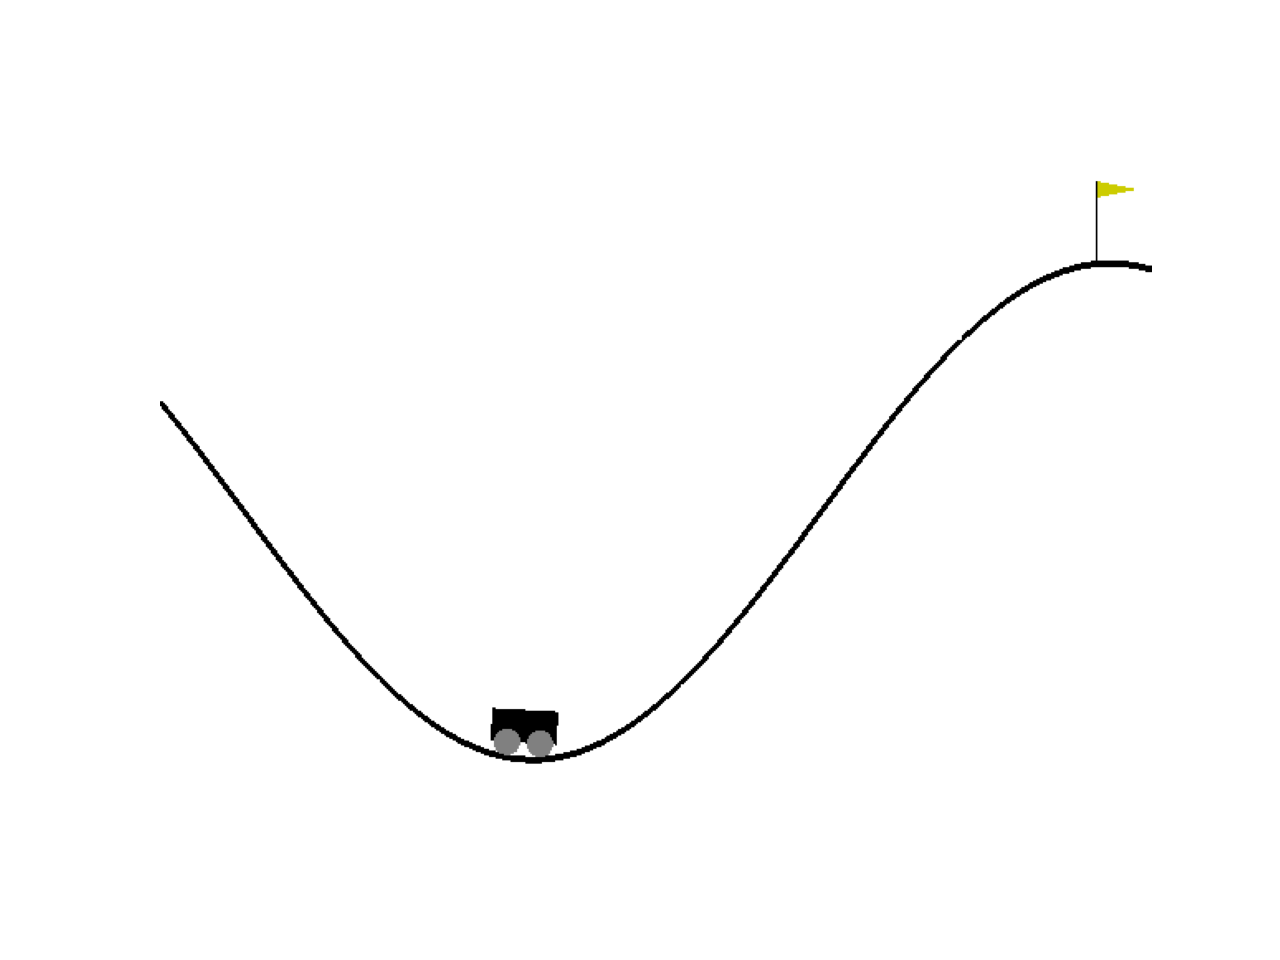

In [2]:
fig = plt.figure()
plt.axis("off")

images = [[plt.imshow(f, animated=True)] for f in frames]

anim = animation.ArtistAnimation(fig, images, interval=50)    
anim.save("recording/car_initial.gif", writer = 'pillow')

In [3]:
def get_tiles(state):
    # tile coding by 8 tilings with each tile 8*8
    
    # normalization
    state = (state - env.observation_space.low) / (env.observation_space.high - env.observation_space.low)
    # descretization
    state = list(map(int, state * 57))
    state = [ max(0,min(56,s)) for s in state]
    
    tiles = [ list(map( lambda s: (s + i) // 8, state)) for i in range(8) ]
    return [ tile[0] * 8 + tile[1] for tile in tiles ]

In [4]:
def q(state, action, w):
    tiles = get_tiles(state)
    # w: 8 tilings * (8*8) tiles * 3 actions
    return sum([ w[i][tiles[i]][action] for i in range(8) ])

In [5]:
def take_action(state, w, epsilon):
    # epsilon-greedy
    if np.random.rand() < epsilon:
        action = np.random.choice([0,1,2])
    else:
        action = np.argmax([ q(state, i, w) for i in range(3) ])
    return action

In [6]:
epsilon = 0.01
alpha = 0.05
gamma = 0.99
w = np.zeros((8,64,3))
step = 0
Delta = 500
ws = []

for episode in range(1000):
    state = env.reset()
    action = take_action(state, w, epsilon)
    for _ in range(1000):
        if step % Delta == 0:
            ws.append(np.copy(w))
        step = step + 1
        
        next_state, reward, done, info = env.step(action)
        
        next_action = take_action(next_state, w, epsilon)
        td = alpha*(reward + (0 if done else gamma*q(next_state, next_action, w)) - q(state,action,w))
        tiles = get_tiles(state)
        for i in range(8):
            w[i][tiles[i]][action] = w[i][tiles[i]][action] + td
        if done:
            break
        
        state, action = next_state, next_action

<IPython.core.display.Javascript object>


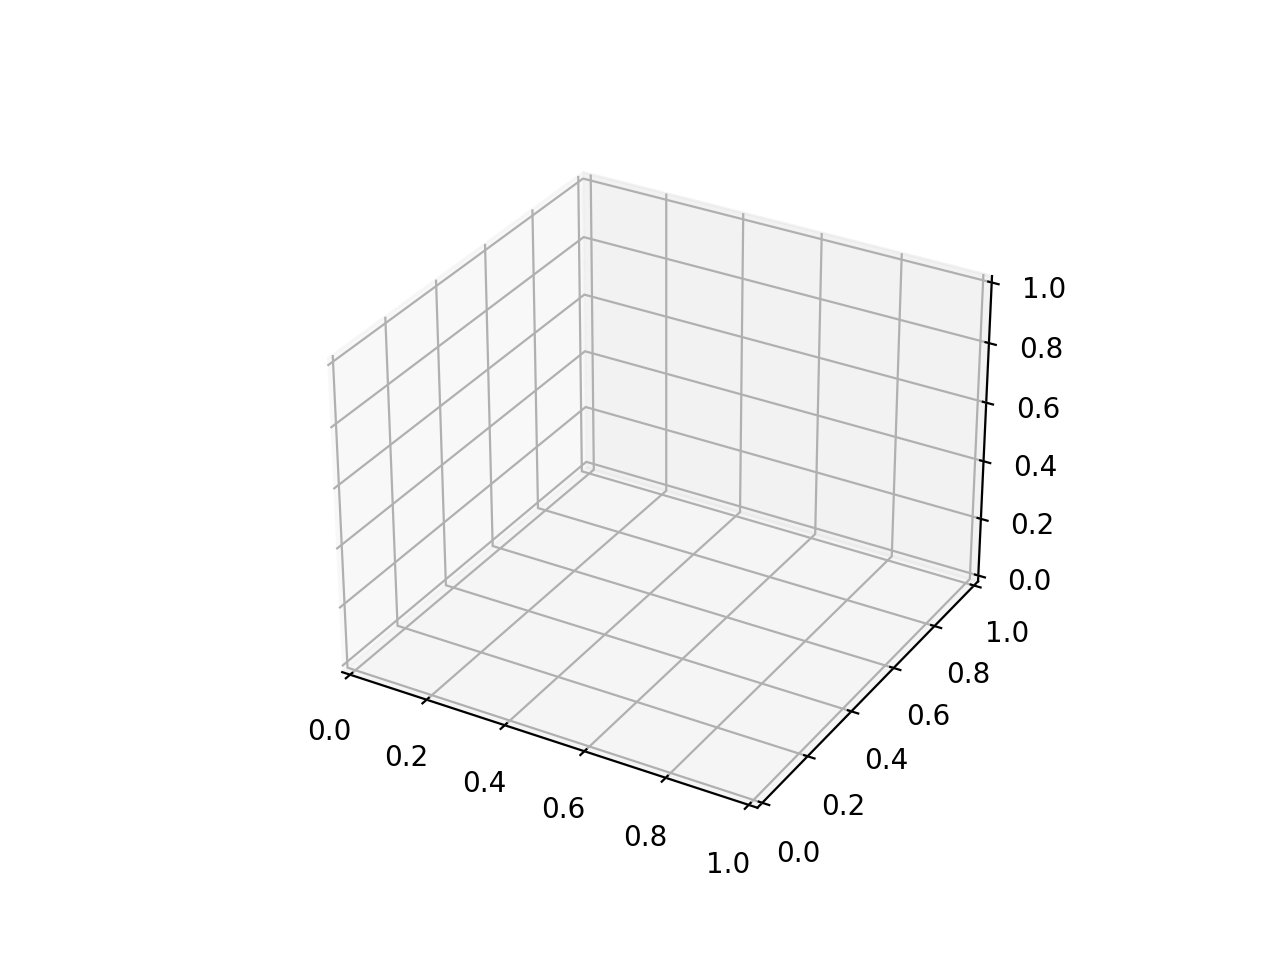

In [10]:
low, high = env.observation_space.low, env.observation_space.high
x = np.linspace(low[0], high[0], 50)
y = np.linspace(low[1], high[1], 50)
x, y = np.meshgrid(x, y)
states = np.c_[np.ravel(x), np.ravel(y)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


def value_plot(step):
    ax.clear()
    z = np.array([ min(0, max([ q(state, i, ws[step]) for i in range(3) ])) for state in states ])
    z = z.reshape(x.shape)
    
    ax.plot_surface(x, y, -z, cmap='bwr', linewidth=0)
    ax.set_zlim(0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    plt.title('step={}'.format(step * Delta))
    
anim = animation.FuncAnimation(fig, value_plot, len(ws), interval=50)
anim.save("recording/car_values.gif", writer = 'pillow')

In [8]:
frames = []
state = env.reset()
for i in range(5):
    index = i*3
    w = ws[index]
    env.reset()
    for _ in range(1000):
        frames.append((env.render(mode='rgb_array'), index))
        action = np.argmax([ q(state, i, w) for i in range(3) ])
        state, reward, done, info = env.step(action)
        if done:
            break
env.close()

<IPython.core.display.Javascript object>


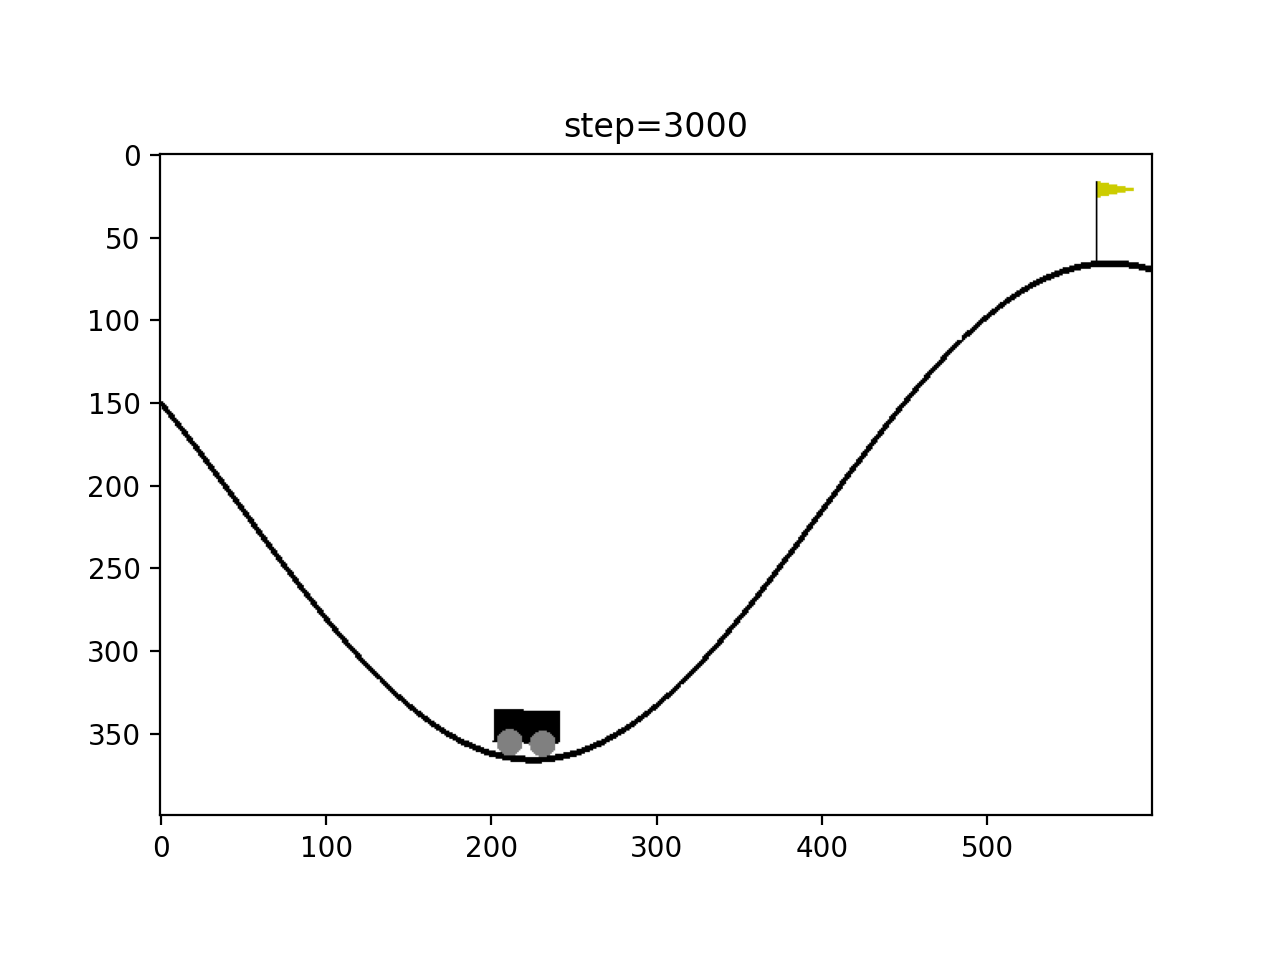

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.axis("off")

images = [[plt.imshow(f, animated=True) ] for (f,index) in frames]
def car_plot(step):
    ax.clear()
    (f,index) = frames[step]
    plt.imshow(f, animated=True)
    plt.title('step={}'.format(index * Delta))
anim = animation.FuncAnimation(fig, car_plot, len(images), interval=50)    
anim.save("recording/car_finished.gif", writer = 'pillow')

In [ ]:
env.close()